# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
DATA_FOLDER = 'Data/' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

#### Description of assumptions and implementation

- Daily month mean is calculated based on the whole period. For instance, if the first day for a specific country is on September 21th and the last day is December 10th, the first and the last months daily mean will be calculated by dividing the total number of data in these months (10 in the given example). The intermediate months are filled up with 0s when data is missing.
- Results concerning December in Liberia seem inaccurate. Data in the csv files seems to describe cumulative numbers instead of per day formatted data. The mean for this last month must be taken carefully.
- For each country, the number of deaths for each day is taken into account, and the new cases confirmed, suspected and probable:
  - Guinea: "Total new cases registered so far", "New deaths registered", "New deaths registered today" (the last one seems to be a different formulation for the same data
  - Liberia: "New Case/s (Suspected)", "New Case/s (Probable)", "New case/s (confirmed)", "Newly reported deaths" (taking into account the spelling variations
  - Sierra Leone: "new_suspected", "new_probable", "new_confirmed" and "death_confirmed"

In [2]:
import pandas as pd
import glob as glob

# Preparing the final dataframe
ebola_data = pd.DataFrame(columns=['Cases', 'Deaths'], dtype=float)

files = glob.glob(DATA_FOLDER + "ebola/**/*.csv")

for file in files:
    # Searching for the country name in filepath and preparing data based on it
    if "guinea" in file:
        data = pd.read_csv(file, index_col=['Date'], parse_dates=['Date'])
        country = "Guinea"
        nb_cases = data[data.Description == 'Total new cases registered so far']['Totals'].fillna(0).values[0]
        nb_deaths = data[data.Description.str.match('^New deaths registered( today)?$')]['Totals'].fillna(0).values[0]
    elif "liberia" in file:
        data = pd.read_csv(file, index_col=['Date'], parse_dates=['Date'])
        country = "Liberia"
        nb_cases = data[data.Variable.str.match('^New (c|C)ase/s .*$')]['National'].fillna(0).astype(float).sum()
        nb_deaths = data[data.Variable == 'Newly reported deaths']['National'].fillna(0).values[0]
    elif "sl" in file:
        data = pd.read_csv(file, index_col=['date'], parse_dates=['date'])
        country = "Sierra Leone"
        nb_cases = data[data.variable.str.match('^new_(suspected|probable|confirmed)$')]['National'].fillna(0).astype(float).sum()
        nb_deaths = data[data.variable == 'death_confirmed']['National'].fillna(0).values[0]
            
    date = data.index[0]
    
    # Creating a new row to be concatenated in the final dataframe
    row = pd.DataFrame({'Deaths': [nb_deaths], 'Cases': [nb_cases], 'Date': [date], 'Country': [country]}).set_index(['Country', 'Date'])
    
    ebola_data = pd.concat([row, ebola_data])

# Sorting data based on date
ebola_data = ebola_data.sort_index()
    
for country in ['Guinea', 'Liberia', 'Sierra Leone']:
    print('\n' + country)
    
    # Resampling data by adding missing months day and calcutating the monthly mean
    print(ebola_data.loc[country].astype(float).resample('D').sum().fillna(0).resample('M').mean())


Guinea
                Cases     Deaths
Date                            
2014-08-31   4.607143   0.607143
2014-09-30  10.466667   1.900000
2014-10-31  34.000000  15.000000

Liberia
                  Cases     Deaths
Date                              
2014-06-30     2.666667   0.933333
2014-07-31     3.032258   1.516129
2014-08-31    10.806452   6.741935
2014-09-30    51.066667  28.833333
2014-10-31    36.741935  22.612903
2014-11-30    13.233333   6.733333
2014-12-31  5178.555556   0.000000

Sierra Leone
                Cases      Deaths
Date                             
2014-08-31  25.150000  293.850000
2014-09-30  39.333333  428.533333
2014-10-31  64.064516  817.838710
2014-11-30  52.666667  786.033333
2014-12-31  15.769231  505.692308


## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [3]:
metadatas = pd.read_excel(DATA_FOLDER + "/microbiome/metadata.xls")

df_list = []
# Creating a list of dataframes with data from each mid data
for index, metadata in metadatas.iterrows():
    # Reading data from mid file
    mid = pd.read_excel(DATA_FOLDER + "/microbiome/" + metadata.BARCODE + ".xls", header=None)
    mid = mid.rename(columns={0: 'name', 1: 'value'})
    
    # Attaching metadata to samples
    mid['group'] = metadata.GROUP
    mid['sample'] = metadata.SAMPLE

    df_list.append(mid)

microbiome = pd.concat(df_list).fillna('unknown')

# Creating a unique multi-index based on three columns
microbiome = microbiome.set_index(['name', 'group', 'sample'])

assert microbiome.index.is_unique, 'Index should be unique'

microbiome

,,,value
name,group,sample,
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",EXTRACTION CONTROL,unknown,7
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrolobus",EXTRACTION CONTROL,unknown,2
"Archaea ""Crenarchaeota"" Thermoprotei Sulfolobales Sulfolobaceae Stygiolobus",EXTRACTION CONTROL,unknown,3
"Archaea ""Crenarchaeota"" Thermoprotei Thermoproteales Thermofilaceae Thermofilum",EXTRACTION CONTROL,unknown,3
"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Methanocellales Methanocellaceae Methanocella",EXTRACTION CONTROL,unknown,7
"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Methanosarcinales Methanosarcinaceae Methanimicrococcus",EXTRACTION CONTROL,unknown,1
"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Methanosarcinales Methermicoccaceae Methermicoccus",EXTRACTION CONTROL,unknown,1
"Archaea ""Euryarchaeota"" Archaeoglobi Archaeoglobales Archaeoglobaceae Ferroglobus",EXTRACTION CONTROL,unknown,1
"Archaea ""Euryarchaeota"" Archaeoglobi Archaeoglobales Archaeoglobaceae Geoglobus",EXTRACTION CONTROL,unknown,1


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [4]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

#### Question 1

The pclass, survived, embarked and sex can be Categorical

In [5]:
titanic = pd.read_excel(DATA_FOLDER + "/titanic.xls")

titanic.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [6]:
titanic.sex = titanic.sex.astype('category')
titanic.pclass = titanic.pclass.replace([1, 2, 3], ['1st', '2nd', '3rd']).astype('category')
titanic.embarked = titanic.embarked.replace(['C', 'Q', 'S'], ['Cherbourg', 'Queenstown', 'Southampton']).astype('category')
titanic.survived = titanic.survived.replace([0, 1], [False, True]).astype('category')
titanic.body = titanic.body.fillna(value=0)

titanic.dtypes

pclass       category
survived     category
name           object
sex          category
age           float64
sibsp           int64
parch           int64
ticket         object
fare          float64
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object

In [7]:
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1st,True,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,Southampton,2,0.0,"St Louis, MO"
1,1st,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,Southampton,11,0.0,"Montreal, PQ / Chesterville, ON"
2,1st,False,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,Southampton,NaN,0.0,"Montreal, PQ / Chesterville, ON"
3,1st,False,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1st,False,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,Southampton,NaN,0.0,"Montreal, PQ / Chesterville, ON"


#### Question 2


In [8]:
%matplotlib inline

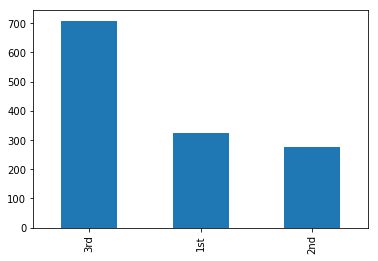

In [9]:
# Using a bar plot for discrete values

titanic.pclass.value_counts().plot(kind='bar')

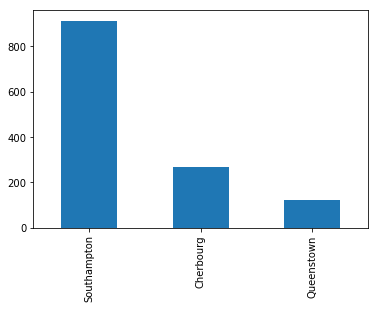

In [10]:
# Using a bar plot for discrete values

titanic.embarked.value_counts().plot(kind='bar')

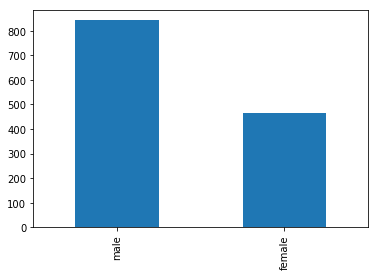

In [11]:
# Using a bar plot for discrete values

titanic.sex.value_counts().plot(kind='bar')

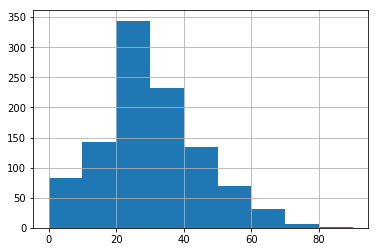

In [12]:
titanic.age.dropna().hist(bins=range(0, 100, 10))

#### Question 3

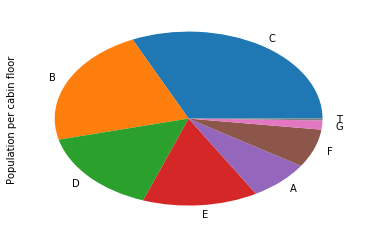

In [13]:
titanic_cabin_floor = titanic["cabin"].dropna().map(lambda x: x[0])

plt = titanic_cabin_floor.value_counts().plot(kind='pie', labels = titanic_cabin_floor.value_counts().index)
plt.set_ylabel('Population per cabin floor')

#### Question 4

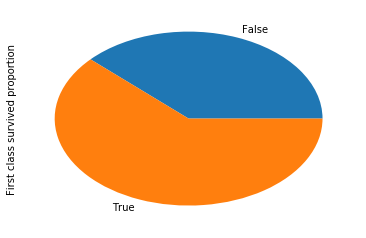

In [14]:
survived = titanic.groupby(['pclass', 'survived']).size()

survived['1st'].plot(kind='pie').set_ylabel('First class survived proportion')

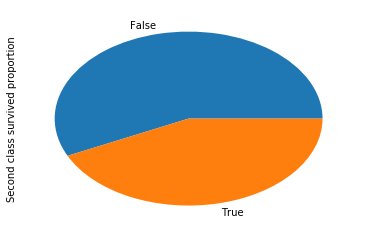

In [15]:
survived['2nd'].plot(kind='pie').set_ylabel('Second class survived proportion')

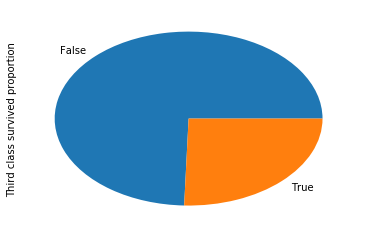

In [16]:
survived['3rd'].plot(kind='pie').set_ylabel('Third class survived proportion')

#### Question 5

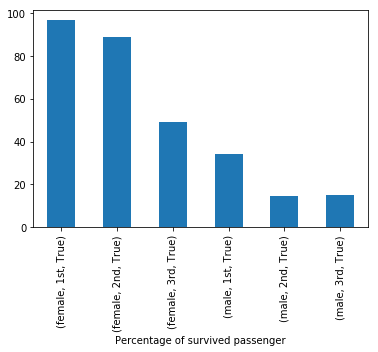

In [17]:
survived = titanic.groupby(['sex', 'pclass', 'survived']).size()

# Using a bar plot for discrete values (and because we are comparing proportions)

plot = survived.groupby(level=['sex', 'pclass']).apply(lambda x: x / x.sum() * 100).filter(like='True', axis=0).plot(kind='bar')
plot.set_xlabel('Percentage of survived passenger')

#### Question 6

In [18]:
titanic['median_age'] = titanic.age > titanic.age.median()
titanic['median_age'] = titanic['median_age'].map(lambda age_category: 'oldest' if age_category else 'yougest')

In [23]:
# Converting booleans to integers as it will be more convenient to sum

titanic.survived = titanic.survived.astype(int)
group_by_cat = titanic.groupby(['median_age', 'sex', 'pclass'])
pd.DataFrame(group_by_cat.survived.sum() / group_by_cat.survived.count()).rename(columns={'survived': 'survived proportion'})

survived proportion
median_age sex    pclass                     
oldest     female 1st                0.967391
                  2nd                0.872340
                  3rd                0.372093
           male   1st                0.302521
                  2nd                0.083333
                  3rd                0.144000
yougest    female 1st                0.961538
                  2nd                0.898305
                  3rd                0.520231
           male   1st                0.416667
                  2nd                0.206897
                  3rd                0.154891